# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

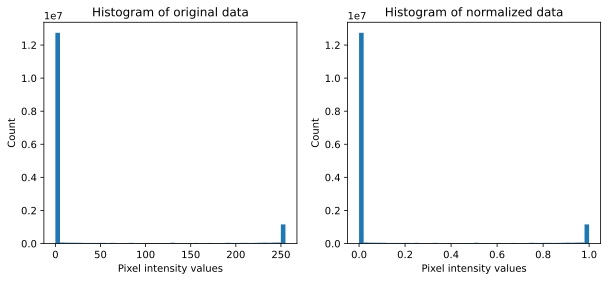

In [3]:
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

# Create train/test groups using DataLoader

In [4]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
batchsize           int              32
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                 Figure           Figure(1000x400)
labels              ndarray          20000: 20000 elems, type `float64`, 160000 bytes (156.25 kb)
labelsT             Tensor           tensor([6, 5, 7,  

# Create the DL model

In [6]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3283, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [8]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [9]:
trainAcc,testAcc,losses,net = function2trainTheModel()


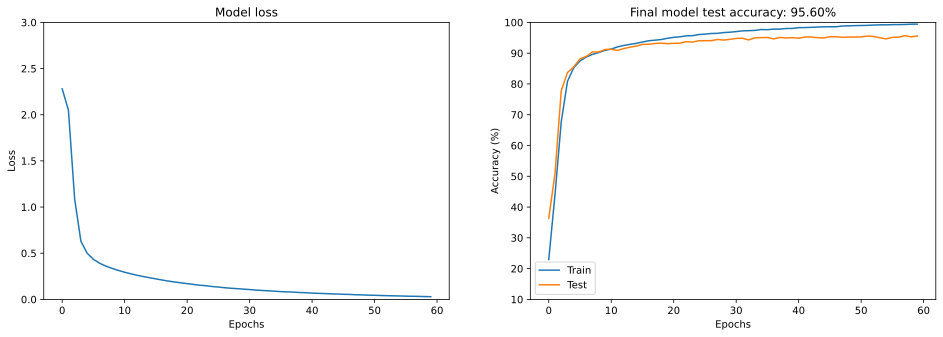

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [11]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-2.6439e+01, -1.8069e+01, -1.7560e+01,  ..., -3.2305e-05,
         -1.8422e+01, -1.0452e+01],
        [-3.2860e+01, -1.8116e+01, -1.6569e+01,  ..., -4.0531e-06,
         -2.1935e+01, -1.4728e+01],
        [-1.9897e+01, -1.4495e+00, -1.1632e+01,  ..., -1.0316e+01,
         -2.6805e-01, -9.4029e+00],
        ...,
        [-1.9223e+01, -8.9207e+00, -1.1873e+01,  ..., -1.4060e+01,
         -3.3072e-03, -1.2881e+01],
        [-2.3891e+01, -2.2072e+01, -2.7068e+01,  ..., -2.2929e+01,
         -1.2474e+01, -1.3431e+01],
        [-1.9994e+01, -1.2592e-03, -1.1928e+01,  ..., -6.9781e+00,
         -8.7229e+00, -1.0455e+01]])

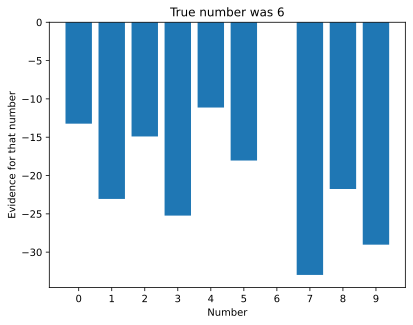

In [12]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  30   36   90  125  133  146  159  186  208  215  259  279  294  305
  317  327  347  359  389  427  432  433  459  464  519  538  572  574
  582  585  612  621  628  631  658  669  673  739  769  801  818  840
  843  844  876  894  939  945  958  959  967 1020 1022 1025 1040 1074
 1105 1123 1131 1170 1194 1213 1243 1257 1264 1274 1378 1411 1423 1427
 1477 1498 1517 1544 1545 1555 1601 1631 1646 1659 1718 1787 1789 1790
 1817 1828 1926 1982]


/tmp/ipykernel_137828/2747607007.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


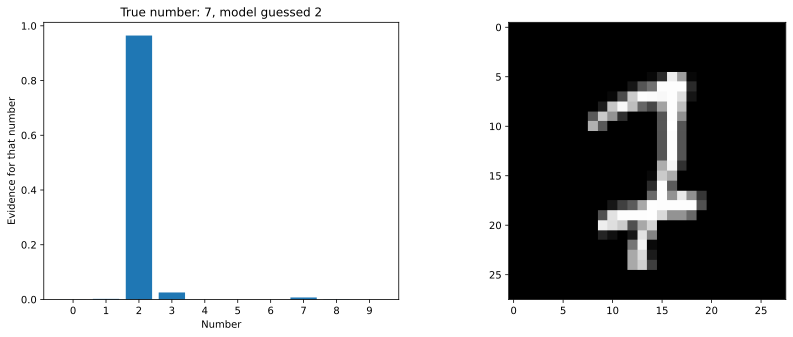

In [13]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [ ]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
# 
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
# 
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
# 
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
# 